# 4. SSTable to Arrow


In [1]:
import pyarrow as pa
import pandas as pd
import cudf
from blazingsql import BlazingContext
from utils import fetch_data

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [2]:
# read data (run this cell once sstable-to-arrow is listening on port 9143)
buffers = fetch_data()
tables = [pa.ipc.open_stream(buf).read_all() for buf in buffers]

receiving table 0


# Demo of cuML using the iris dataset

In [3]:
cdf = cudf.DataFrame.from_arrow(tables[0])
cdf = cdf.rename(columns={
    'partition_key': 'sepal_length',
    'clustering_key_0': 'sepal_width',
    'clustering_key_1': 'petal_length',
    'clustering_key_2': 'petal_width',
    'clustering_key_3': 'species'
})
cdf.head()

sepal_length  sepal_width  petal_length  petal_width  species
0           7.4          2.8           6.1          1.9        2
1           4.7          3.2           1.3          0.2        0
2           4.7          3.2           1.6          0.2        0
3           5.7          2.5           5.0          2.0        2
4           5.7          2.6           3.5          1.0        1

/home/ubuntu/anaconda3/envs/rapids_with_arrow/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


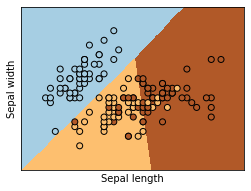

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.linear_model import LogisticRegression
from cuml.linear_model import LogisticRegression

X = cdf.iloc[:, :2]  # we only take the first two features.
Y = cdf.iloc[:, 4]

# Create an instance of Logistic Regression Classifier and fit the data.
logreg = LogisticRegression(C=1e5)
logreg.fit(X, Y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X.iloc[:, 0].min() - .5, X.iloc[:, 0].max() + .5
y_min, y_max = X.iloc[:, 1].min() - .5, X.iloc[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X.iloc[:, 0].to_array(), X.iloc[:, 1].to_array(), c=Y.to_array(), edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

# Deduplicating SSTables

In [ ]:
bc = BlazingContext()
for i, table in enumerate(tables):
    new_table = cudf.DataFrame.from_arrow(table.flatten())
    bc.create_table(f'sstable_{i}', new_table.rename(columns={'value': 'val'}))

In [ ]:
pd.concat([table.to_pandas() for table in tables])

In [ ]:
bc.sql('''
SELECT partition_key, val
FROM sstable_0
WHERE NOT EXISTS
(SELECT _local_del_time_partition FROM sstable_2 WHERE sstable_0.partition_key = sstable_2.partition_key)
''')